## //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

https://www.geeksforgeeks.org/find-paths-given-source-destination/

In [1]:
# Импортирую нужные библиотеки

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType
from pyspark.sql.functions import *

from graphframes import *
import networkx as nx

import pandas as pd
import numpy as np
import scipy as sp

from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%matplotlib inline

import time 
import sys

import findspark
findspark.init()

In [2]:
# Создам сессию Spark, настрою конфигруацию

In [3]:
spark = (SparkSession.builder
                    .config('spark.executor.memory', '36g')
                    .config('spark.executor.cores', '3')
                    .config('spark.executor.instance', '2')
                    .config('spark.driver.cores', '1')
                    .config('spark.driver.memory', '12g')
                    #.config('spark.extraListeners', 'sparkmonitor.listener.JupyterSparkMonitorListener')
                    #.config('spark.driver.extraClassPath', '/home/kei/.local/lib/python3.8/site-packages/sparkmonitor/listener_2.12.jar')
                    .getOrCreate())

sc = spark.sparkContext

spark.sparkContext._conf.getAll()

[('spark.app.id', 'local-1675004373829'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1675004371811'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '43401'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.warehouse.dir',
  'file:/home/kei/Desktop/Projects-/Innostage/spark-warehouse'),
 ('spark.driver.host', '192.168.1.131'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
# Сделаю чекпоинт для будущего разложения графа на компоненты.

In [5]:
sc.setCheckpointDir('/home/kei/Desktop/Projects-/Innostage/Checkpoints')

## Stage 1: Стартовые данные. Обработка и фильтрация.

In [7]:
# Создам датафрейм, загрузив начальный набор данных.

In [5]:
data_DF = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/srcdst-150221.csv',
                    format= 'csv', sep= ';', inferSchema= 'true', header= 'true')

In [22]:
# Отображу данные для понимания с чем предстоит работать. Посмотрю тысячу 

In [6]:
data_DF.show(1000)

+----------------+---------------+-----+
|             src|            dst|  cnt|
+----------------+---------------+-----+
|            null|           null|   73|
|            null|   10.77.171.33|   32|
|            null|   10.77.172.16|   16|
|            null|  10.77.172.253|    1|
|            null|   10.77.181.10|   31|
|            null|   10.77.181.11|    4|
|            null|    10.77.181.2|   23|
|            null|    10.77.181.3|   27|
|            null|    10.77.181.4|   28|
|            null|    10.77.181.6|   23|
|            null|    10.77.181.7|   37|
|            null|    10.77.181.8|   31|
|            null|    10.77.181.9|   30|
|            null|    10.77.182.2|    2|
|            null|114.108.175.146|    1|
|            null| 125.194.32.161|    1|
|            null| 125.194.32.164|    1|
|            null| 125.194.32.167|    2|
|            null| 125.194.32.170|    1|
|            null| 125.194.32.177|    4|
|            null| 125.194.32.178|    8|
|            nul

In [15]:
# Узнаю количество строк представляющих собой src - dst

In [6]:
data_DF.count()

7864324

In [16]:
# В начальном наборе данных очень много значений, с которым будет тяжело работать или те, которые не нужны.
# Выполню sql запрос используя методы spark, удалив значения по условию, и использую формулу regex для удаления 
#    значений формата Firewall. 

In [23]:
cleared_df = data_DF.where('not (src is null) and not (dst is null)'). \
                where('not (src = "127.0.0.1") and not (dst = "127.0.0.1")'). \
                where('not (src = "0.0.0.0") and not (dst = "0.0.0.0")'). \
                where('not(src = "1") and not(dst = "1")'). \
                where('not (src = dst) and not (dst = src)'). \
                where(col('src').rlike("(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)")). \
                where(col('dst').rlike("(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)")). \
                select('src', 'dst')

In [24]:
# Для упрощения дальнейшей работы, сохраню обработанный датафрейм в формате parquet.

In [ ]:
cleared_df.select(col('src'), col('dst')) \
                  .write.format('parquet').option('header', 'true') \
                  .save("/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_1/cleared_df.parquet")
    

In [19]:
# Теперь можно загружать этот датафрейм сразу при запуске jupyter.

In [16]:
cleared_df = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_1/cleared_df.parquet',
                    format= 'parquet', sep= ';', inferSchema= 'true', header= 'true')

In [7]:
# Взгляну на новый набор данных. Вижу что они "пригодны" для работы с ними.

In [27]:
cleared_df.show(20)

+------------+---------------+
|         src|            dst|
+------------+---------------+
|     0.0.0.1| 125.194.32.168|
|    0.0.0.60| 125.194.32.168|
|0.199.82.141|255.255.255.255|
|  0.77.160.4| 125.194.32.185|
|  0.77.181.3| 125.194.32.167|
|     1.0.0.0| 125.194.32.188|
|     1.0.0.0| 125.194.32.190|
|     1.0.0.0|255.255.255.255|
| 1.0.128.150| 125.194.32.161|
| 1.0.128.158| 125.194.32.186|
| 1.0.128.174| 125.194.32.180|
| 1.0.130.112| 125.194.32.161|
|  1.0.130.12| 125.194.32.170|
|  1.0.130.12| 125.194.32.176|
|  1.0.130.12| 125.194.32.185|
| 1.0.130.186| 125.194.32.168|
|  1.0.130.32| 125.194.32.170|
|  1.0.130.47| 125.194.32.187|
|  1.0.130.75| 125.194.32.179|
| 1.0.131.165| 125.194.32.181|
+------------+---------------+
only showing top 20 rows



In [23]:
# Узнаю снова количество строк в наборе данных

In [24]:
print('DataFrame has ',cleared_df.count(), 'values')

DataFrame has  7853176 values


In [25]:
# Узнаю количество уникальных src значений

In [26]:
print('Unique src values is: ', cleared_df.select('src').distinct().count()) 


Unique src values is:  1822130


In [27]:
# Узнаю количество уникальных dst значений

In [28]:
print('Unique dst values is: ', cleared_df.select('dst').distinct().count())

Unique dst values is:  52219


In [29]:
# Зная уникальные значения каждого столбца, зная их связи, можно создать граф.

In [30]:
nodes = (cleared_df.select('src').distinct()).union(cleared_df.select('dst').distinct()).distinct()

edge = cleared_df

vertex = nodes.select(col('src').alias('id'))

- Вершины графа это набор уникальных значений src объедененных с уникальными значениями dst

- Поскольку IP адрес это и входной и выходной адрес, их нужно объеденить.

- В роли ребер(связей) выступает отношение src к dst. Это можно увидеть в исходном df.

- Так же, чтобы реализовать граф, необходимо переименовать src -> id

In [31]:
graph = GraphFrame(vertex, edge)

In [32]:
# Найдем вершину, в которой больше всего связей.


# Метод degrees вернет мне сумму входящих и исходящих ребер из вершины.

In [33]:
degrees = graph.degrees

In [34]:
# Просортировав результат, можно увидеть что есть вершины с очень большим количеством вход\исходящих ребер.

In [35]:
degrees.sort(desc('degree')).show(150)

+---------------+------+
|             id|degree|
+---------------+------+
| 125.194.32.161|355864|
| 125.194.32.167|269709|
| 125.194.32.177|263339|
| 125.194.32.178|262741|
| 125.194.32.164|248831|
| 125.194.32.166|247349|
| 125.194.32.169|238709|
| 125.194.32.188|237923|
| 125.194.32.189|237896|
| 125.194.32.190|236584|
| 125.194.32.174|231415|
| 125.194.32.163|231358|
|  125.194.32.69|230183|
| 125.194.32.179|230017|
| 125.194.32.168|229952|
| 125.194.32.185|228840|
| 125.194.32.170|228656|
| 125.194.32.172|228581|
| 125.194.32.187|228514|
| 125.194.32.180|228199|
| 125.194.32.165|228082|
| 125.194.32.175|227941|
| 125.194.32.182|227743|
| 125.194.32.184|227597|
| 125.194.32.176|227221|
| 125.194.32.183|225679|
| 125.194.32.160|225430|
| 125.194.32.191|224987|
| 125.194.32.162|224918|
| 125.194.32.181|224658|
| 125.194.32.173|224614|
| 125.194.32.186|224196|
| 125.194.32.171|223738|
|    10.77.172.2| 11611|
|  125.194.32.32|  1093|
|   10.77.171.51|  1087|
|   10.77.189.12|  1013|


In [39]:
# Переведу получившийся датафрейм в объект pandas

In [40]:
degrees_pd = degrees.toPandas()

In [41]:
# Настрою pandas так, чтобы отображались все строки

In [42]:
pd.set_option("display.max_rows", None)

In [44]:
# Узнаю сколько вершин у которых свое число degrees 

In [45]:
degrees_pd['degree'].value_counts()

1         1095736
2          266000
3          110720
33          80432
4           61543
5           38886
6           27035
7           19995
8           15204
9           12157
32          11841
10          10126
11           8640
12           7377
13           6372
14           5895
31           5449
15           5214
16           4817
17           4398
18           4058
19           3783
30           3714
20           3443
29           3212
21           3170
22           3112
23           3015
25           2890
26           2889
24           2878
28           2875
27           2864
34            532
35            305
37            263
36             29
40              3
38              3
39              2
55              2
61              2
237923          1
230183          1
230017          1
225430          1
228514          1
227221          1
355864          1
224614          1
236584          1
238709          1
220             1
53              1
1013            1
1087      

In [46]:
# Теперь можно разложить граф на его компоненты.

In [10]:
connected_comp = graph.connectedComponents()

In [51]:
# Просортирую результат по компонентам. 

In [52]:
connected_comp.sort(desc(col('component'))).show(500)

+---------------+------------+
|             id|   component|
+---------------+------------+
| 169.254.15.163|876173331462|
|169.254.255.255|876173331462|
|   10.77.160.29|876173328516|
|   10.77.160.28|876173328516|
|       1.0.3.88|635655159812|
|      1.0.7.255|635655159812|
|       1.0.3.60|635655159812|
|      1.0.3.255|635655159812|
|       1.0.3.43|635655159812|
|    10.11.4.255|163208757362|
|     10.11.4.55|163208757362|
|198.152.254.153| 42949678046|
| 198.102.57.152| 42949678046|
|  198.176.15.72| 42949678046|
|  198.231.41.19| 42949678046|
| 198.141.226.72| 42949678046|
| 198.49.160.187| 42949678046|
| 198.145.99.171| 42949678046|
|198.163.124.166| 42949678046|
|198.251.189.111| 42949678046|
|  198.138.35.66| 42949678046|
| 198.214.84.127| 42949678046|
|104.128.246.122| 42949678046|
|  198.79.222.43| 42949678046|
|  198.114.12.26| 42949678046|
| 198.27.117.185| 42949678046|
|198.171.203.106| 42949678046|
|  198.105.93.27| 42949678046|
| 198.160.235.27| 42949678046|
| 198.20

In [53]:
# Получившийся результат можно проверить по количеству уникальных компонентов

In [12]:
pd_comp = connected_comp.toPandas()

pd_comp['component'].value_counts()

0               1840667
5987                221
42949678046          41
635655159812          5
5969                  4
163208757362          2
876173328516          2
876173331462          2
Name: component, dtype: int64

In [13]:
comp0 = connected_comp.select('id').where('component == 0')


In [16]:
comp0.select(col('id')) \
                .write.format('parquet').option('header', 'true') \
                .save('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_1/comp0.parquet')

In [18]:
comp0.count()

1840667

## Stage 2: Удаление слабосвязных вершин.

In [15]:
comp0 = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_1/comp0.parquet')

In [7]:
# Теперь, зная сумму вход\исходящих ребер у вершин, я выделю самые "заметные" и выпишу их в отдельный список.

# Поскольку набор из 38 адрессов будет достаточно трудоемким для обработки на моем компьютере, я разделил их частями.

In [71]:
main_nodes_list = ['125.194.32.161', '125.194.32.167','125.194.32.177','125.194.32.178','125.194.32.164','125.194.32.166', '125.194.32.169','125.194.32.188','125.194.32.189','125.194.32.190','125.194.32.174','125.194.32.163','125.194.32.69','125.194.32.179','125.194.32.168','125.194.32.185','125.194.32.170','125.194.32.172','125.194.32.187','125.194.32.180','125.194.32.165','125.194.32.175','125.194.32.182','125.194.32.184','125.194.32.176','125.194.32.183','125.194.32.160','125.194.32.191','125.194.32.162','125.194.32.181','125.194.32.173','125.194.32.186','125.194.32.171','10.77.172.2','125.194.32.32','10.77.171.51','10.77.189.12','125.194.32.64']


In [10]:
# Напишу алгоритм и реализую его функцией.

**Алгоритм**

Поскольку connectedComponents() находит компоненты составляющие подграфы исходного графа, есть вероятность, что
если удалить наиболее крупную вершину, то нарушится единая сеть, которая была связана лишь через эту вершину.
Так что чем больше входящих\исходящих ребер есть в вершине, тем больше вероятность что это ключевой элемент подграфа. Это я и проверю.

1. Создаем массив основных крупных вершин. 
2. Беру одну вершину из списка и удаляю ее из основного набора данных.
3. Создаю граф.
4. Раскладываю граф на компоненты
5. Проверяю получившийся результат
6. Провожу группировку по количеству записей из уникальных компонентов
7. Далее выбираю те компоненты, количество которых не равно 1 (новая ветка)
8. Далее возвращаю вершину которая была в списке самых соединенных вершин и убираю ее из списка.
9. Повторяю операцию для других сильносвязных вершин. 

In [7]:
def delete_weaklylinked_vertices(graph_c0, most_edged_vertices_list, graph_edges, path_save_file, file_name):
    timing = time.time()
    path = path_save_file + file_name
    
    for node in most_edged_vertices_list:
    
#   |   вершину из списка удаляю из вершин и ребер графа.
        new_vertices = graph_c0.select('id').where(col('id') != node)
        new_edges = graph_edges.where(col('src') != node).where(col('dst') != node)
#   |
#   |   создаю новый граф без этой вершины
        new_graph = GraphFrame(new_vertices, new_edges)
#   | 
#   |   раскладываю его на компоненты
        new_connected_comp = new_graph.connectedComponents()
#  
#   |   группирую компоненты по "components" и узнаю количество каждого компонента
        group_by_comp = new_connected_comp.groupBy('component').count()
#   |
#   |   выбираю только те компоненты, количество которых != 1
        unique_comp = group_by_comp.select('component').where(col('count') != 1).collect()
#  
#   |   создаю список этих компонентов
        component_list = [i.component for i in unique_comp]
#  
#   |   далее выбираю все id из датафрейма connectedComponents с условием что компонент есть в списке
        new_df_comp = new_connected_comp.select('id').where(col('component').isin(component_list))
#   
#   |   возвращаю вершину обратно
        used_node_df = spark.createDataFrame([(node)], 'string').toDF('id')
        new_nodes_data = new_df_comp.union(used_node_df)
#   |
    
#   |   сохраняю в формате parquet объекты id
    new_nodes_data.select('id') \
                  .write.format('parquet').mode('overwrite').option('header', 'true') \
                  .save(path)
    
    
    done_time = time.time() - timing
    return print(' Done for: {0} minutes'.format(done_time // 60), '\n' \
                ,'Algorithm removed: ', graph_c0.count() - new_nodes_data.count(), ' weakly linked nodes.')

## Запуск алгоритма: -> Innostage Task 4 - Remove WLN



In [13]:
new_nodes = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_2/nodes.parquet/')

In [16]:
print(' Done for: {0} minutes'.format(38 * 4), '\n' \
     ,'Algorithm removed', comp0.count() - new_nodes.count(), ' weakly linked vertices.', '\n' \
     ,'New dataframe has {0} unique vertices'.format(new_nodes.count()))

 Done for: 152 minutes 
 Algorithm removed 1044148  weakly linked vertices. 
 New dataframe has 796519 unique vertices


## Stage 3: Обработка новых узлов.

In [6]:
#new nodes
new_nodes = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_2/nodes.parquet/')
new_nodes.createOrReplaceTempView('new_nodes')

#main df with edges
cleared_df = spark.read.load('/home/kei/Desktop/data/innostage/innostage_task_4/data/Stage_1/cleared_df.parquet/')
cleared_df.createOrReplaceTempView('cleared_df')


main_nodes_list = ['125.194.32.161', '125.194.32.167','125.194.32.177','125.194.32.178','125.194.32.164','125.194.32.166', '125.194.32.169','125.194.32.188','125.194.32.189','125.194.32.190','125.194.32.174','125.194.32.163','125.194.32.69','125.194.32.179','125.194.32.168','125.194.32.185','125.194.32.170','125.194.32.172','125.194.32.187','125.194.32.180','125.194.32.165','125.194.32.175','125.194.32.182','125.194.32.184','125.194.32.176','125.194.32.183','125.194.32.160','125.194.32.191','125.194.32.162','125.194.32.181','125.194.32.173','125.194.32.186','125.194.32.171','10.77.172.2','125.194.32.32','10.77.171.51','10.77.189.12','125.194.32.64']


In [7]:
new_nodes.printSchema()

root
 |-- id: string (nullable = true)



In [8]:
main_df = cleared_df.where(col('src').isin(main_nodes_list)).where(col('dst').isin(main_nodes_list)).distinct()

In [9]:
graph = nx.DiGraph()

In [10]:
#create data for graph
nodes_list = [i.src for i in (main_df.select('src').distinct().collect())]
edges_list = [(i.src, i.dst) for i in (main_df.select('src', 'dst').distinct().collect())]

#add data to graph
graph.add_nodes_from(nodes_list)
graph.add_edges_from(edges_list)

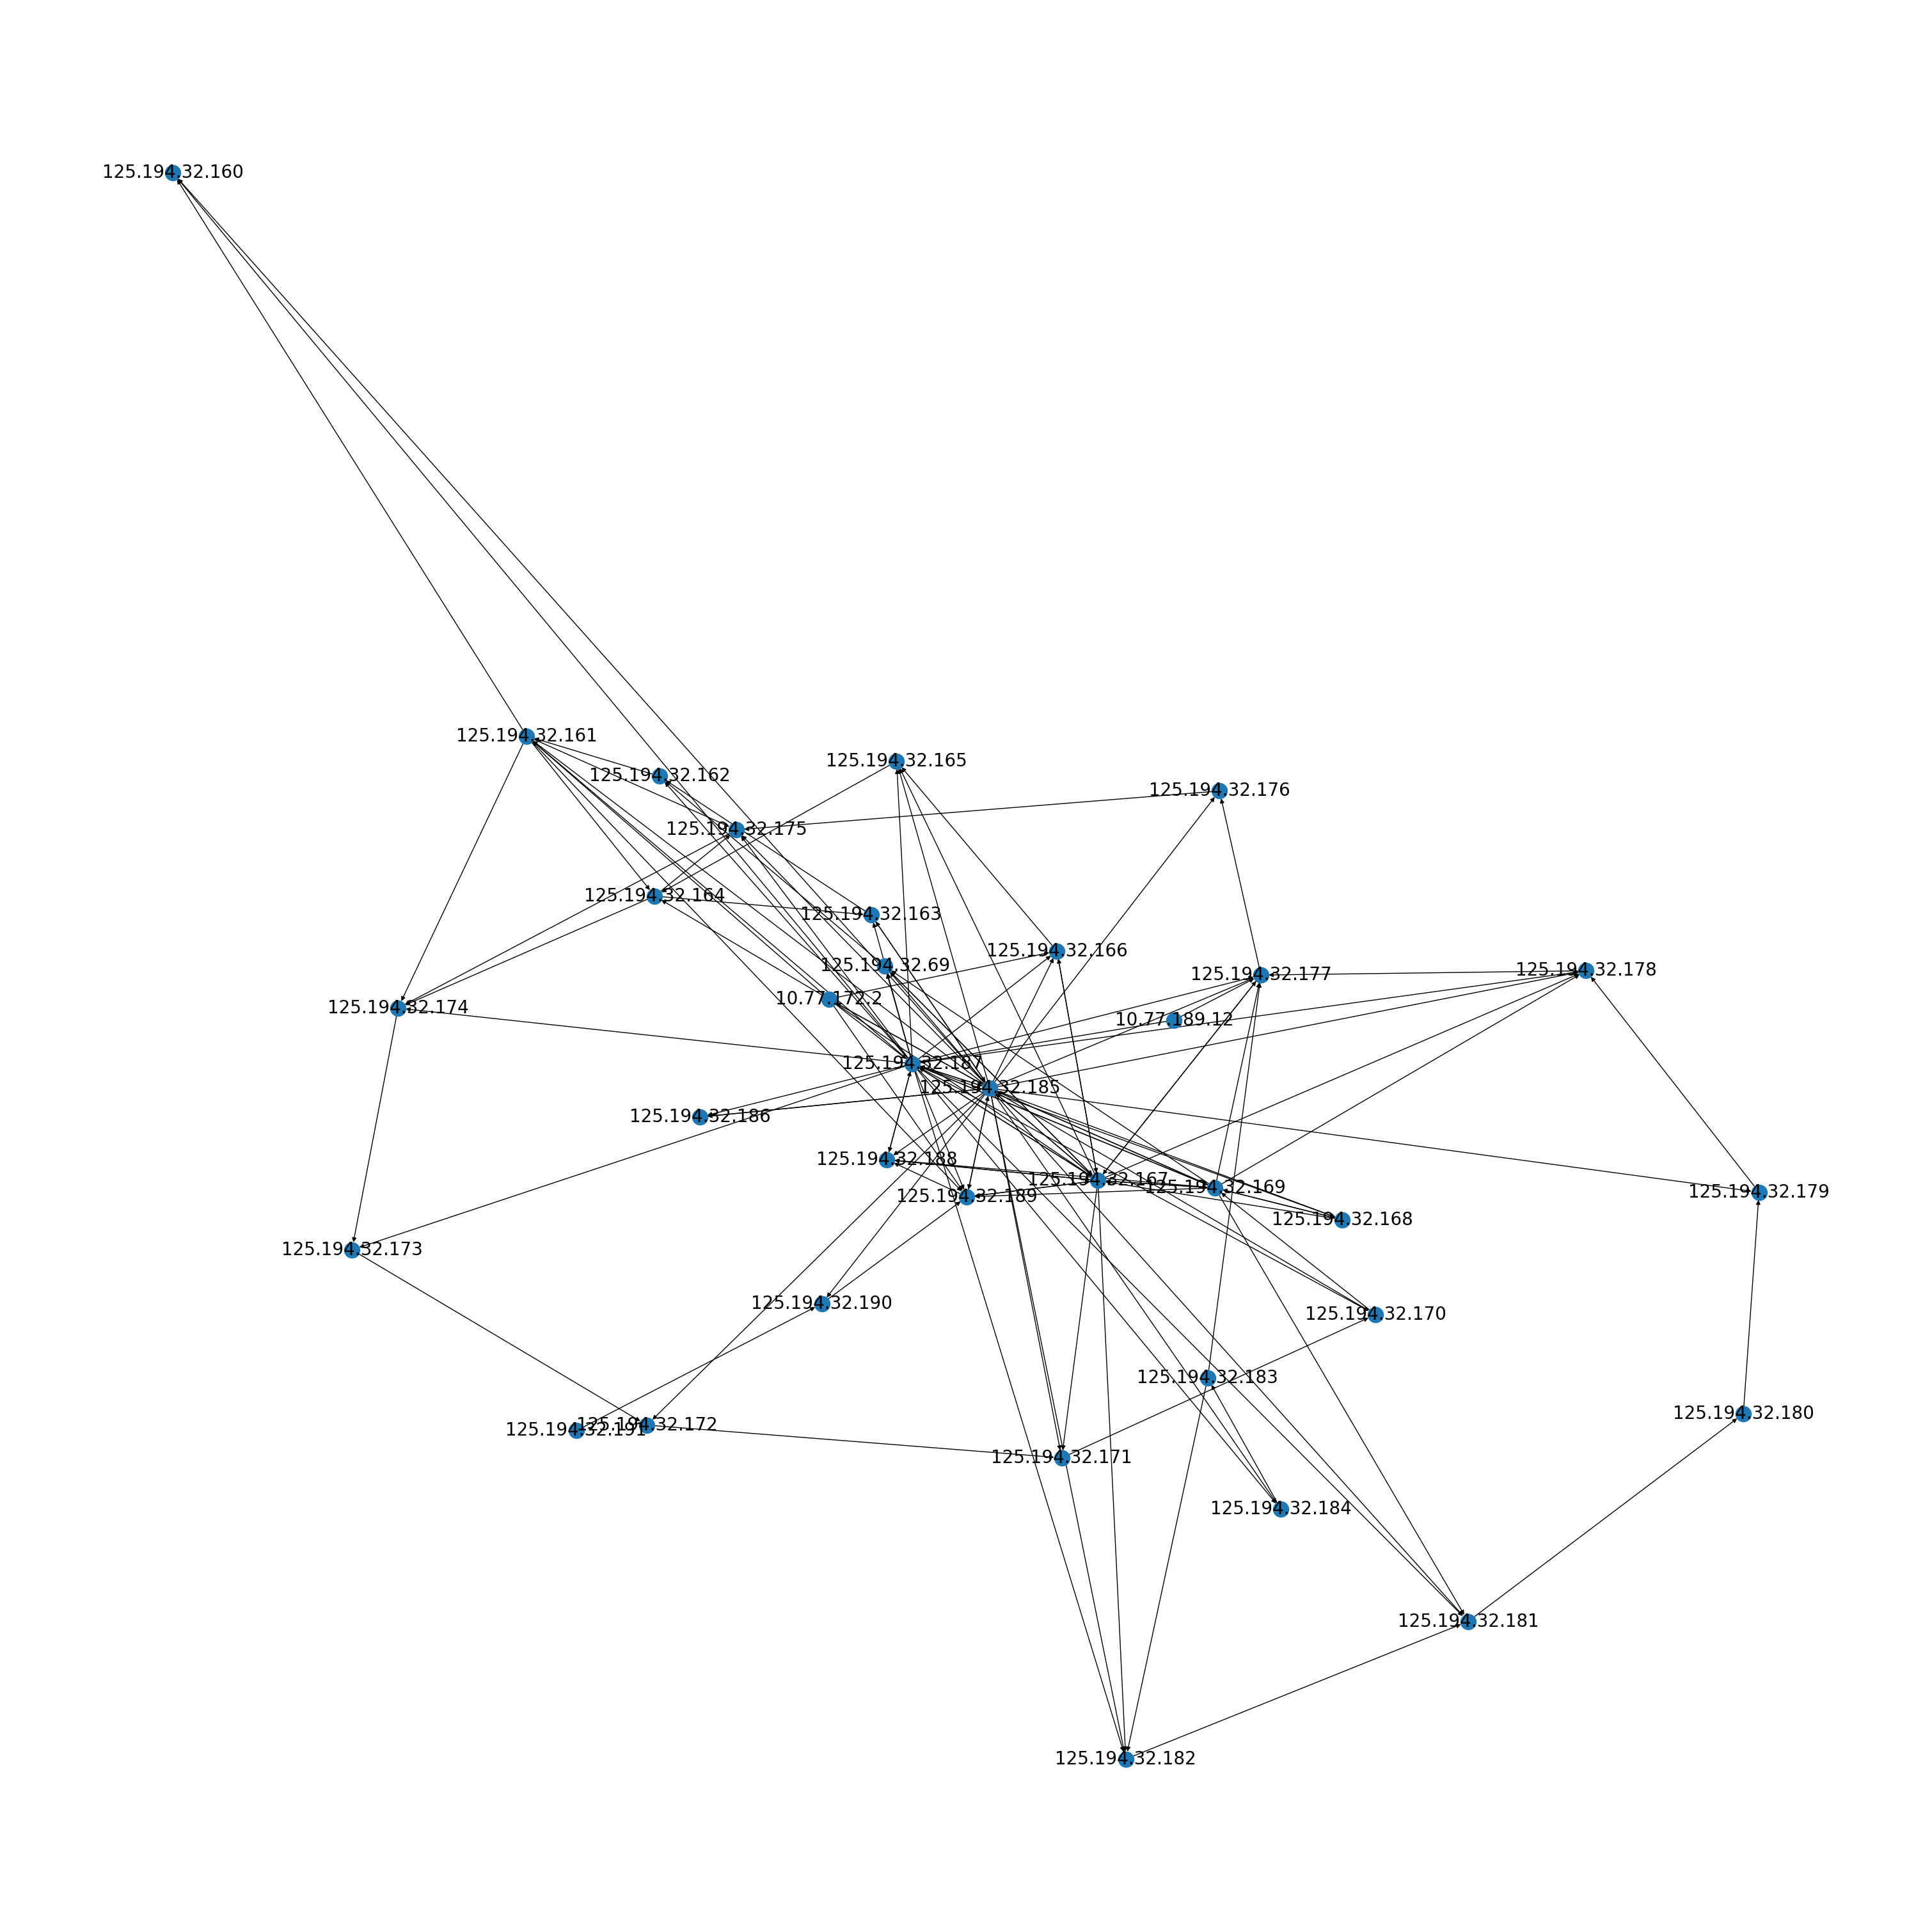

In [149]:
plt.figure(figsize=[30,30])

nx.draw(graph, with_labels = True, font_size = 20)

In [68]:
# This class represents a directed graph
# using adjacency list representation
class Graph:
  
    def __init__(self, vertices):
        # No. of vertices
        self.V = vertices
         
        # default dictionary to store graph
        self.graph = defaultdict(list)
        
        self.long_path = []

    #function to add a list of edges to graph (like (src, dst))
    def addEdges(self, edges_list):
        for u,v in edges_list:
            self.graph[u].append(v)
            
    #def UpdateLongPath(self, path):
    #    if len(long_path) < len(path):
    #        self.long_path = path
    #        print(self.long_path)
    
    def GetLongPath(self):
        return self.long_path
    
  
    '''A recursive function to print all paths from 'u' to 'd'.
    visited[] keeps track of vertices in current path.
    path[] stores actual vertices and path_index is current
    index in path[]'''
    def AllPathsUtil(self, u, d, visited, path):
 
        # Mark the current node as visited and store in path
        visited[u]= True
        path.append(u)
 
        # If current vertex is same as destination, then print
        # current path[]
        if u == d:
            #print(path)
            if len(self.long_path) <= len(path):
                self.long_path = [j for j in path]
        else:
            # If current vertex is not destination
            # Recur for all the vertices adjacent to this vertex
            for i in self.graph[u]:
                if visited[i]== False:
                    self.AllPathsUtil(i, d, visited, path)
                     
        # Remove current vertex from path[] and mark it as unvisited
        path.pop()
        visited[u]= False
    
    # Prints all paths from 's' to 'd'
    def CalculateAllPaths(self, s, d):
 
        # Mark all the vertices as not visited
        visited = {}
        for i in self.V:
            visited[i] = False
        
 
        # Create an array to store paths
        path = []
 
        # Call the recursive helper function to print all paths
        self.AllPathsUtil(s, d, visited, path)

In [67]:
def process_and_display(src_dst_df):
    from tqdm import tqdm
    start_time = time.time()
    
#collecting data from dataframe
    data = src_dst_df.collect()
    
#select unique nodes from dataframe
    unique_nodes = (((src_dst_df.select('src').distinct()). \
                     union(src_dst_df.select('dst').distinct())).distinct().collect())
    
#list of all unique nodes
    nodes_list = [unique_nodes[i][0] for i in range(unique_nodes.__len__())]
    
#creating graph obj
    graph = Graph(nodes_list)
    
#collecting and add edges to graph
    edges_list = [(data[i][0], data[i][1]) for i in range(data.__len__())]
    graph.addEdges(edges_list)
    
#display 
    print('DataFrame include {0} unique nodes and {1} edges.'.format(nodes_list.__len__(), edges_list.__len__()))
    print('Preparing for recursion... ')
    
#recurssion
    print('Start process...')
    
    for current_vertex in tqdm(range(nodes_list.__len__())):
        for target in range(nodes_list.__len__()):
            if current_vertex != target:
                graph.CalculateAllPaths(nodes_list[current_vertex], nodes_list[target])

                
    done_time = time.time() - start_time
    print(' Done for: {0} minutes'.format(done_time // 60))
    return graph.GetLongPath()
                      

In [66]:
process_and_display(main_df)

DataFrame include 35 unique nodes and 123 edges.
Preparing for recursion... 
Start process...


100%|████████████████████████████████████████████████████████████████████████████████████████| 35/35 [02:28<00:00,  4.25s/it]

 Done for: 2.0 minutes


['125.194.32.191',
 '125.194.32.190',
 '125.194.32.189',
 '125.194.32.188',
 '125.194.32.167',
 '125.194.32.166',
 '125.194.32.165',
 '125.194.32.164',
 '125.194.32.163',
 '125.194.32.185',
 '10.77.172.2',
 '125.194.32.187',
 '125.194.32.184',
 '125.194.32.183',
 '125.194.32.182',
 '125.194.32.181',
 '125.194.32.180',
 '125.194.32.179',
 '125.194.32.178',
 '125.194.32.177',
 '125.194.32.176',
 '125.194.32.175',
 '125.194.32.174',
 '125.194.32.173',
 '125.194.32.172',
 '125.194.32.171',
 '125.194.32.170',
 '125.194.32.169',
 '125.194.32.69',
 '125.194.32.162',
 '125.194.32.161',
 '125.194.32.160']